This notebook contains the exploratory data analysis of the twitter data from gambling twitter handles.

In [464]:
from ds_digital_ads import base_config, BUCKET_NAME, PROJECT_DIR
from ds_digital_ads.getters.data_getters import load_s3_data, get_s3_data_paths

import os
from tqdm import tqdm

import altair as alt
import matplotlib.pyplot as plt

import pandas as pd
import ast
import re

from datetime import datetime
import emoji
from collections import Counter
from wordcloud import WordCloud

#analyse images in more detail
from PIL import Image
import pytesseract
import io

## Load functions and variables

these include:
- parameters
- functions to:
    - clean up the data
    - use nesta-specific designs for the plots
    - extract emojis from text
    - extract text from images


In [465]:
# save graphs
today = datetime.today().strftime("%y%m%d")
graph_dir = str(PROJECT_DIR / f"outputs/figures/twitter_eda/{today}/")

if not os.path.exists(graph_dir):
    print(f"Creating {graph_dir} directory")
    os.makedirs(graph_dir)
else:
    print(f"{graph_dir} directory already exists")

/Users/india.kerlenesta/Projects/ds_digital_ads/outputs/figures/twitter_eda/231220 directory already exists


In [494]:
#load parameters
analysis_date = base_config["analysis_date_stamp"]
processed_data_path = base_config['RECENT_SEARCH_TWITTER_S3_DATA_COLLECTION_FOLDER']
production = base_config['production']

processed_data_path = 'data_collection/gambling_tweets/processed'
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'

In [467]:
NESTA_COLOURS = [
    #    "#0000FF",
    "#FDB633",
    "#18A48C",
    "#9A1BBE",
    "#EB003B",
    "#FF6E47",
    "#646363",
    "#0F294A",
    "#97D9E3",
    "#A59BEE",
    "#F6A4B7",
    "#D2C9C0",
    "#000000",
]


def nestafont(font: str = "Century Gothic"):
    """Define Nesta fonts"""
    return {
        "config": {
            "title": {"font": font, "anchor": "start"},
            "axis": {"labelFont": font, "titleFont": font},
            "header": {"labelFont": font, "titleFont": font},
            "legend": {"labelFont": font, "titleFont": font},
            "range": {
                "category": NESTA_COLOURS,
                "ordinal": {
                    "scheme": NESTA_COLOURS
                },  # this will interpolate the colors
            },
        }
    }


alt.themes.register("nestafont", nestafont)
alt.themes.enable("nestafont")

plt.rcParams['font.family'] = 'Century Gothic'

In [498]:
## functions 

def clean_tweet(tweet: str) -> str:
    """
    clean up tweet to get rid of:
        - urls
        - bad characters
    """
    tweet = tweet.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('  ', ' ')
    modified_text = re.sub(r'https\S*', '', tweet)
    
    return modified_text.strip()

def extract_emoji(text: str):
    """
    Extracts emoji from text
    """
    extracted_emoji = emoji.emoji_list(text)
    return [t.get('emoji') for t in extracted_emoji]

## 0. Load data
- load twitter media table
- load twitter core table
- load tweet images

#### 0.2 load data paths

In [470]:
## load data paths
media_path = os.path.join(processed_data_path, f"media_table_production_{production}_{analysis_date}.csv")
core_data_path = os.path.join(processed_data_path, f"core_table_{production}_{analysis_date}.csv")

images_path = os.path.join(processed_data_path, 'images')

#### 0.3 load in data from s3

In [471]:
#Load data
media_df = load_s3_data(BUCKET_NAME, media_path)
tweets_df = load_s3_data(BUCKET_NAME, core_data_path)

image_files = get_s3_data_paths(BUCKET_NAME, images_path, file_types=['*.jpg'])
print(f'there are {len(image_files)} images in the {images_path} folder')

there are 589 images in the data_collection/gambling_tweets/processed/images folder


In [38]:
#load in images from tweets 
images = []
for image_file in tqdm(image_files):
    images.append(load_s3_data(BUCKET_NAME, image_file))

100%|██████████| 589/589 [03:08<00:00,  3.12it/s]


## 1. initial EDA

Let's explore the data (core, media and images) to get a high level sense of the tables.

#### 1.1 initial EDA of the core dataset

In [472]:
##clean up core dataset slightly

#convert list columns to lists
cols = ['hashtags', 'url_titles', 'url_descriptions', 'mentions']

for col in cols:
    tweets_df[col] = tweets_df[col].apply(ast.literal_eval)
    
#make created_at a datetime

tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])

#get rid of url in text
tweets_df['clean_tweet'] = tweets_df['text'].apply(clean_tweet)
tweets_df['emoji'] = tweets_df['clean_tweet'].apply(extract_emoji)

tweets_df = tweets_df[tweets_df['clean_tweet'] != ""]
tweets_df.drop_duplicates(subset=['id'], inplace=True)


In [473]:
min_date = tweets_df.created_at.min().date()
max_date = tweets_df.created_at.max().date()

print(f"there are {tweets_df.shape[0]} tweets in the core table")
print(f'the tweets are collected between {min_date} and {max_date}')

print('we collect information on...')
print(tweets_df.columns)

there are 646 tweets in the core table
the tweets are collected between 2023-12-05 and 2023-12-20
we collect information on...
Index(['id', 'media_id', 'name', 'created_at', 'lang', 'text',
       'public_metrics_retweet_count', 'public_metrics_reply_count',
       'public_metrics_like_count', 'public_metrics_quote_count',
       'public_metrics_bookmark_count', 'public_metrics_impression_count',
       'hashtags', 'url_titles', 'url_descriptions', 'mentions', 'clean_tweet',
       'emoji'],
      dtype='object')


In [474]:
##value counts charts

#most tweets per name
tweets_per_name_df = (tweets_df
                      .groupby('name')
                      .id
                      .count()
                      .sort_values(ascending=False)
                      .head(10)
                      .reset_index()
                      .rename(columns={'id': 'tweet_count'}))

top_names_chart = alt.Chart(tweets_per_name_df).mark_bar(opacity=0.8, color=NESTA_COLOURS[1]).encode(
    x=alt.X('tweet_count', title='# of Tweets'),
    y=alt.Y('name', sort='-x')).properties(title='Top Twitter Handles by # of Tweets')


#most common hashtags
hashtags_df = (tweets_df
               .explode('hashtags')
               .hashtags
               .value_counts()
               .head(10)
               .reset_index())

hashtags_chart = alt.Chart(hashtags_df).mark_bar(opacity=0.8, color=NESTA_COLOURS[0]).encode(
    y=alt.Y('hashtags', title='Hashtag', sort='-x'),
    x=alt.X('count')).properties(title='Top Hashtags by # of Mentions')

#most common emojis
emojis_df = (tweets_df
             .explode('emoji')
             .emoji
             .value_counts()
             .head(10)
             .reset_index())

emoji_chart = alt.Chart(emojis_df).mark_bar(opacity=0.8, color=NESTA_COLOURS[5]).encode(
    y=alt.Y('emoji', title='emoji', sort='-x'),
    x=alt.X('count')).properties(title='Top emoji by # of Mentions')

In [475]:
#most popular tweets (drop down for impressions/likes/retweets)
metric = 'public_metrics_retweet_count'
popular_tweets_df = (tweets_df
                     .sort_values(metric, ascending=False)
                     .head(10)
                     [['clean_tweet', 'name', metric]])

popular_tweets_chart_retweet = alt.Chart(popular_tweets_df).mark_bar(opacity=0.8, color=NESTA_COLOURS[2]).encode(
    x=alt.X(metric, title=f'# of {metric.split("_")[2].capitalize()}s'),
    y=alt.Y('clean_tweet', title='',sort='-x')).properties(title=f'Top Tweets by # of {metric.split("_")[2].capitalize()}s')
                     

metric = 'public_metrics_like_count'
popular_tweets_df = (tweets_df
                     .sort_values(metric, ascending=False)
                     .head(10)
                     [['clean_tweet', 'name', metric]])

popular_tweets_chart_like = alt.Chart(popular_tweets_df).mark_bar(opacity=0.8, color=NESTA_COLOURS[3]).encode(
    x=alt.X(metric, title=f'# of {metric.split("_")[2].capitalize()}s'),
    y=alt.Y('clean_tweet', title='',sort='-x',  axis=alt.Axis(labelLimit=200))).properties(title=f'Top Tweets by # of {metric.split("_")[2].capitalize()}s')
                 

In [476]:
value_counts_chart = (top_names_chart | hashtags_chart | emoji_chart) & (popular_tweets_chart_retweet | popular_tweets_chart_like)

#add title
value_counts_chart = value_counts_chart.properties(
    title={
      "text": ["Value Counts Charts"], 
      "subtitle": ["", ""],
    }
)

value_counts_chart.save(f"{graph_dir}/value_counts_chart.html")

value_counts_chart

alt.VConcatChart(...)

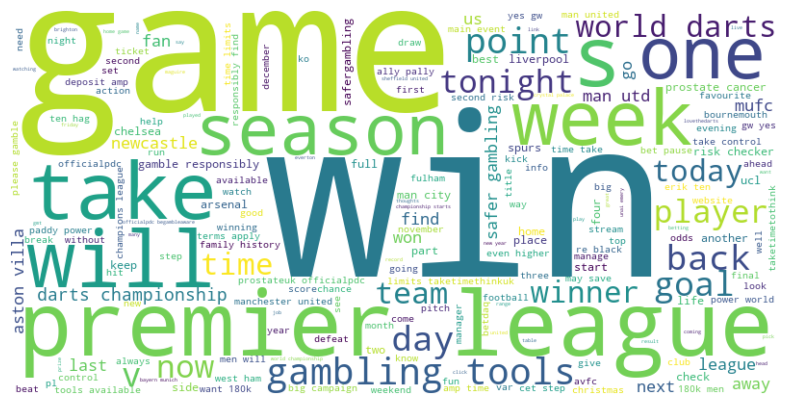

<Figure size 640x480 with 0 Axes>

In [477]:
#create word cloud


all_tweets = " ".join(tweets_df['clean_tweet'].to_list()).lower()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

plt.savefig(f'{graph_dir}/wordcloud.png')


#### 1.2 initial EDA of the media dataset

In [481]:
## for the media data

print(f'there are {tweets_df.media_id.nunique()} unique media ids')
print(f'{round(tweets_df.media_id.nunique() / tweets_df.shape[0], 2)*100}% of tweets contain media.')

media_df.isna().sum()

there are 591 unique media ids
91.0% of tweets contain media.


url                 0
media_id            0
type                0
public_metrics    449
duration_ms       449
alt_text          644
image_name          0
dtype: int64

In [482]:
#media graph

media_type_df = media_df.type.value_counts().reset_index()

media_chart = alt.Chart(media_type_df).mark_bar(opacity=0.8, color=NESTA_COLOURS[4]).encode(
    y=alt.Y('type', title='type'),
    x=alt.X('count', title='# of Tweets')).properties(title='Media Types by # of Tweets')

media_chart.save(f'{graph_dir}/media_chart.html')

#### 1.3 initial EDA of the images

In [535]:
#Extract text from image 
image_df = pd.DataFrame(image_files, columns=['image_file'])
image_df['image_name'] = image_df['image_file'].apply(lambda x: x.split('/')[-1])

image_text_list = []
for image in tqdm(images):
    image_bytes = image.getvalue()
    loaded_image = image = Image.open(io.BytesIO(image_bytes))
    text = pytesseract.image_to_string(loaded_image)
    image_text_list.append(text)
    
image_df['image_text'] = image_text_list
image_df['clean_image_text'] = image_df['image_text'].apply(lambda x: clean_tweet(x))
image_df = image_df[image_df['clean_image_text'] != '']

media_df_images = pd.merge(media_df, image_df, on='image_name', how='left')
media_df_images.to_csv(f"s3://{BUCKET_NAME}/{media_path}", index=False)

100%|██████████| 589/589 [02:01<00:00,  4.86it/s]


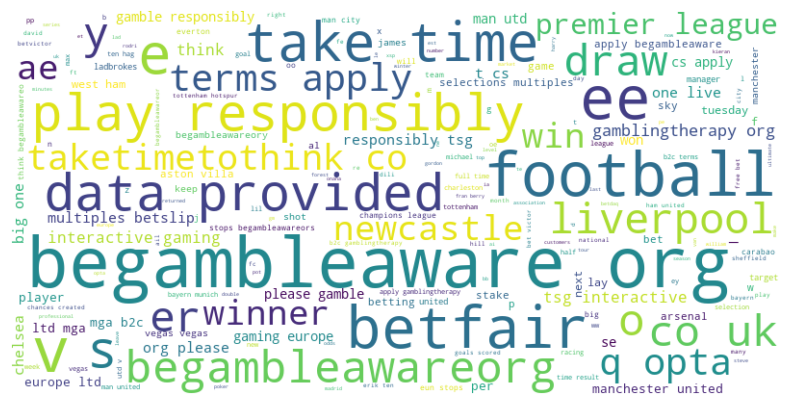

<Figure size 640x480 with 0 Axes>

In [545]:
#wordcloud for text from images

image_text = " ".join(image_df['clean_image_text'].to_list()).lower()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(image_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

plt.savefig(f'{graph_dir}/image_text_wordcloud.png')

## 2. identifying 'ad' tweets

In [490]:
#method 1: identify tweets as an ad if the hashtag contains 'ad'

tweets_df_hash = tweets_df.explode('hashtags').reset_index(drop=True)
tweets_df_hash.dropna(subset=['hashtags'], inplace=True)

print(len(tweets_df_hash[tweets_df_hash['hashtags'].str.startswith('ad')]))

#conclusion" no tweets contain the hashtag 'ad'

print(len(tweets_df_hash[tweets_df_hash['hashtags'].str.startswith('sponsored')]))
print(len(tweets_df_hash[tweets_df_hash['hashtags'].str.startswith('sponsor')]))

#conclusion" no tweets contain the hashtag 'sponsored'/'sponsor'


#method 2: identify tweets as an ad if the extracted text contains 'ad'/'advert'/'sponsored' etc.

0
0
0
